In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../src')
from utils.get_prices import get_prices

from pathlib import Path
from collections import defaultdict

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 5)

DATA_PATH = Path('../scorecard/data')
BASKET_NAME = 'scorecard_single_ticker'
TICKER_PATH = DATA_PATH / '{}.csv'.format(BASKET_NAME)

In [2]:
tickers = pd.read_csv(TICKER_PATH, header=None, names=['Ticker'], squeeze=True)
tickers

0       AAL
1      AAPL
2      ABNB
3      ACIA
4      ADBE
       ... 
160     ZEN
161      ZG
162      ZM
163    ZNGA
164      ZS
Name: Ticker, Length: 165, dtype: object

In [4]:
start = '2018-01-01'
end = '2021-02-09'

price_filename = '_'.join(['prc', BASKET_NAME, start, end, 'Y']) + '.csv'
price_filepath = DATA_PATH / price_filename

if Path(price_filepath).exists():
    print("Found existing price file. Reading...")
    all_prices = pd.read_csv(price_filepath, header=[0,1], index_col=0,
                         parse_dates=True)
    print("Prices read from: ", price_filepath)
else:
    all_prices = get_prices(
        tickers, start, end,
        out_path=price_filepath)

Gaps found and filled in  ('close', 'DELL')  :
['20181224']
Gaps found and filled in  ('close', 'DKNG')  :
['20190816']
Gaps found and filled in  ('close', 'FUBO')  :
['20180424', '20190228']
Gaps found and filled in  ('high', 'DELL')  :
['20181224']
Gaps found and filled in  ('high', 'DKNG')  :
['20190816']
Gaps found and filled in  ('high', 'FUBO')  :
['20180424', '20190228']
Gaps found and filled in  ('low', 'DELL')  :
['20181224']
Gaps found and filled in  ('low', 'DKNG')  :
['20190816']
Gaps found and filled in  ('low', 'FUBO')  :
['20180424', '20190228']
Gaps found and filled in  ('open', 'DELL')  :
['20181224']
Gaps found and filled in  ('open', 'DKNG')  :
['20190816']
Gaps found and filled in  ('open', 'FUBO')  :
['20180424', '20190228']
Gaps found and filled in  ('volume', 'DELL')  :
['20181224']
Gaps found and filled in  ('volume', 'DKNG')  :
['20190816']
Gaps found and filled in  ('volume', 'FUBO')  :
['20180424', '20190228']
Gaps found and filled in  ('adj_close', 'DELL')  

In [14]:
close_prices = all_prices['adj_close']
hi_prices = all_prices['adj_high']

# (Theoretical) close-to-high

Strategy imagining we can always sell at the high the day after we buy

In [8]:
import strats.threshold_momentum as tm
from evaluation.threshold_momentum import calculate_stats_for_thresholds

stats_df = calculate_stats_for_thresholds(
    close_prices, hi_prices, tm.threshold_momentum_returns)
last_3y_stats_df = calculate_stats_for_thresholds(
    close_prices.last('3Y'), hi_prices.last('3Y'), tm.threshold_momentum_returns)

In [9]:
print(f'Stats from {start}')
stats_df.sort_values('sharpe', ascending=False).head(10)

Stats from 2018-01-01


,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std
167,ABNB,0.063811,0.03,1.589999,14,14,0,0.040132
2,ABNB,0.059518,0.02,1.506404,16,16,0,0.039510
332,ABNB,0.063729,0.04,1.466420,12,12,0,0.043459
497,ABNB,0.064287,0.05,1.411818,11,11,0,0.045535
602,PING,0.030578,0.05,1.379523,31,28,3,0.022166
272,PING,0.035080,0.03,1.353275,71,68,3,0.025922
288,SNOW,0.054093,0.03,1.325850,20,19,1,0.040798
437,PING,0.033360,0.04,1.303319,52,49,3,0.025597
375,DKNG,0.055693,0.04,1.267191,65,60,5,0.043950
478,VEEV,0.024409,0.04,1.263749,40,38,2,0.019314


In [10]:
def compare_returns(close_prices, strategy_returns, threshold, ticker):
    ticker_start = close_prices[ticker].first_valid_index()

    close_returns = close_prices[ticker].pct_change()
    close_returns = close_returns[close_returns > threshold]
    plt.vlines(
        close_returns.index, 0, close_returns,
        color='green', linestyle='-', label=f'Returns exceeding {threshold * 100}%')
    strategy_returns[ticker].loc[ticker_start:].fillna(0).plot(label='Momentum strategy returns')

    plt.legend()
    plt.title(ticker)

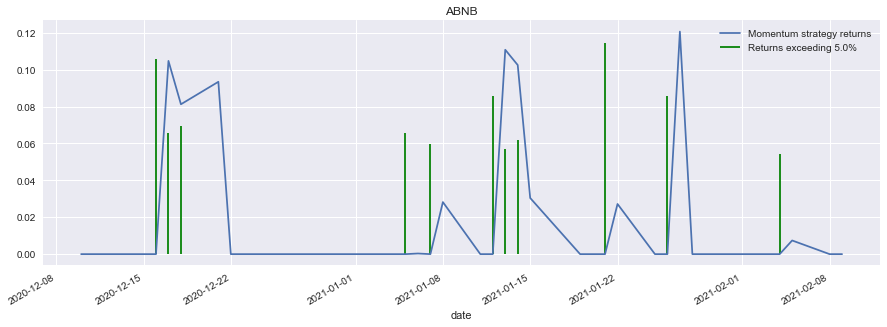

In [11]:
returns = tm.threshold_momentum_returns(close_prices, hi_prices, 0.05)
compare_returns(close_prices, returns, 0.05, 'ABNB')

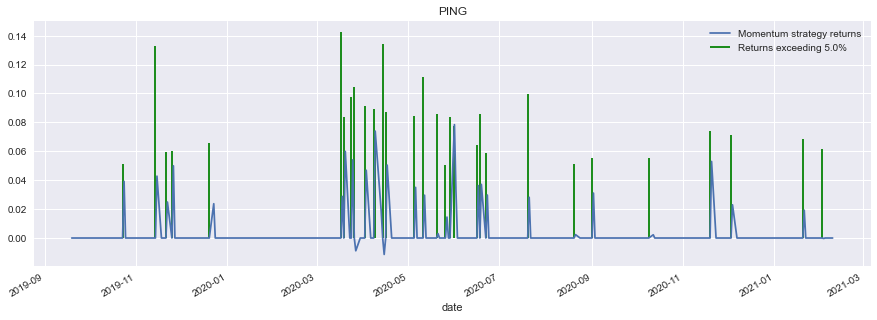

In [12]:
compare_returns(close_prices, returns, 0.05, 'PING')

In [13]:
print(f"Stats from {close_prices.last('3Y').index[0].date()}")
last_3y_stats_df.sort_values('sharpe', ascending=False).head(10)

Stats from 2019-01-02


,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std
167,ABNB,0.063811,0.03,1.589999,14,14,0,0.040132
658,ZNGA,0.039320,0.05,1.569727,9,9,0,0.025049
2,ABNB,0.059518,0.02,1.506404,16,16,0,0.039510
332,ABNB,0.063729,0.04,1.466420,12,12,0,0.043459
497,ABNB,0.064287,0.05,1.411818,11,11,0,0.045535
602,PING,0.030578,0.05,1.379523,31,28,3,0.022166
272,PING,0.035080,0.03,1.353275,71,68,3,0.025922
288,SNOW,0.054093,0.03,1.325850,20,19,1,0.040798
437,PING,0.033360,0.04,1.303319,52,49,3,0.025597
333,ACIA,0.019744,0.04,1.300288,11,11,0,0.015184


# Evaluating Sharpe values using bootstrap sampling

Look at AirBnB for `threshold = 0.05`.

In [11]:
stats_df[(stats_df['ticker'] == 'ABNB')]

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std
2,ABNB,0.065056,0.02,1.592027,13,13,0,0.040864
167,ABNB,0.069220,0.03,1.743796,12,12,0,0.039695
332,ABNB,0.068849,0.04,1.654596,11,11,0,0.041611
497,ABNB,0.069975,0.05,1.601820,10,10,0,0.043685


In [12]:
from evaluation.bootstrap import bootstrap

def stats_fn(samples):
    mean = samples.mean()
    std = samples.std()
    
    return {
        'sharpe': mean / std,
        'std': std,
        'mean': mean
    }

def visualize_bootstrap(baseline, df, df_loc):
    realised_stats = df.loc[df_loc]
    ticker = realised_stats['ticker']
    
    bootstrap_stats = bootstrap(
        baseline[ticker],
        stats_fn,
        realised_stats['count'], 10000)

    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

    keys = ['std', 'mean', 'sharpe']
    axes = [ax1, ax2, ax3]

    for key, ax in zip(keys, axes):
        bootstrap_vals = [s[key] for s in bootstrap_stats]
        sns.histplot(bootstrap_vals, ax=ax)
        ax.set_title(f'Bootstrap distribution of {key}')
        ax.vlines(
            [realised_stats[key]],
            0, 500, linestyle='--', color='orange')
    ax4.axis('off')
    plt.tight_layout()
    plt.suptitle(f'{ticker} Bootstrap statistics')
    
    p_value = np.mean([
        s['sharpe'] > realised_stats['sharpe']
        for s in bootstrap_stats
    ])
    print('Estimated p-value for %s sharpe ratio of %.2f is %.4f' % (
        ticker, realised_stats['sharpe'], p_value))

In [13]:
close_to_high = (hi_prices - close_prices.shift()) / close_prices.shift()

Estimated p-value for ABNB sharpe ratio of 1.60 is 0.2273


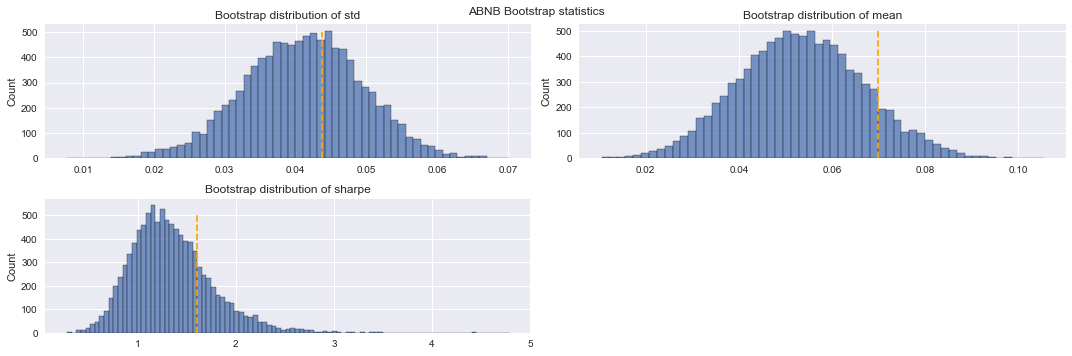

In [14]:
# close-to-high is our baseline since we assume we can always sell at the high in this strategy.
visualize_bootstrap(close_to_high, stats_df, 497)

## Estimating p-value for all results

In [15]:
def p_value_for_row(baseline, row):
    ticker = row['ticker']
    count = row['count']
    sharpe = row['sharpe']
    
    bootstrap_stats = bootstrap(
        baseline[ticker],
        stats_fn,
        count, 1000)
    
    p_value = np.mean([
        b_stats['sharpe'] > sharpe
        for b_stats in bootstrap_stats
    ])
    return p_value

In [16]:
stats_df['p_value'] = stats_df.apply(
    lambda row: p_value_for_row(close_to_high, row),
    axis=1)

In [17]:
stats_df.sort_values('p_value', ascending=True).head(10)

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std,p_value
540,DKNG,0.053020,0.05,1.244225,50,46,4,0.042613,0.000
45,DKNG,0.053121,0.02,1.169400,100,92,8,0.045426,0.000
210,DKNG,0.051769,0.03,1.162943,86,78,8,0.044515,0.000
375,DKNG,0.056229,0.04,1.275543,64,59,5,0.044083,0.000
427,NIO,0.065847,0.04,0.997378,136,124,11,0.066021,0.004
592,NIO,0.070613,0.05,1.032372,107,97,9,0.068398,0.004
97,NIO,0.058717,0.02,0.935036,203,183,18,0.062796,0.011
78,JD,0.020265,0.02,0.924593,340,291,45,0.021918,0.018
262,NIO,0.062002,0.03,0.932632,160,144,14,0.066481,0.018
272,PING,0.035179,0.03,1.348072,70,67,3,0.026096,0.019


In [18]:
# m = stats_df.shape[0]
m = stats_df['ticker'].unique().size

bonferroni_p = 0.05 / m
sidak_p = 1 - (1 - 0.05) ** (1 / m)

print(f'Bonferroni: {bonferroni_p}')
print(f'Sidak: {sidak_p}')

Bonferroni: 0.00030303030303030303
Sidak: 0.0003108201362433949


In [19]:
stats_df[stats_df['p_value'] < sidak_p]

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std,p_value
45,DKNG,0.053121,0.02,1.169400,100,92,8,0.045426,0.0
210,DKNG,0.051769,0.03,1.162943,86,78,8,0.044515,0.0
375,DKNG,0.056229,0.04,1.275543,64,59,5,0.044083,0.0
540,DKNG,0.053020,0.05,1.244225,50,46,4,0.042613,0.0


Estimated p-value for DKNG sharpe ratio of 1.24 is 0.0000


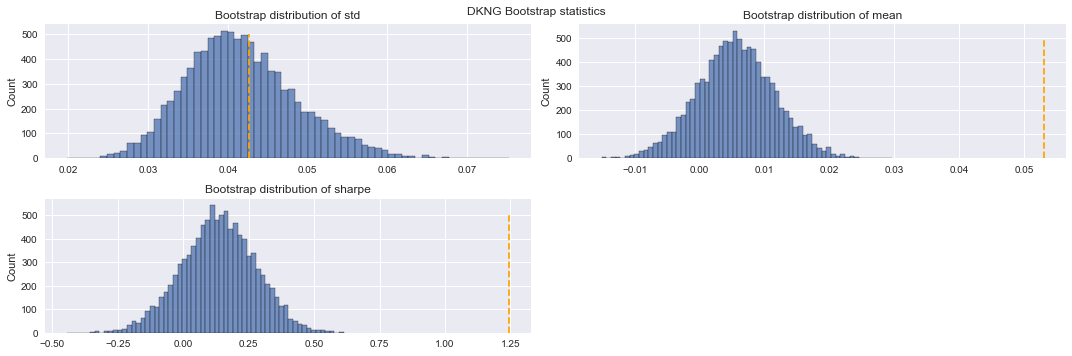

In [20]:
visualize_bootstrap(close_prices.pct_change(), stats_df, 540)

# The need to move beyond Sharpe / std dev

We're potentially diminishing our signal by just looking at Sharpe as std deviation doesn't capture the skew of returns. More relevant than skew probably is just proportion of returns that are positive, or merely that skew is non-negative. This thought and section is a WIP

In [21]:
returns = tm.threshold_momentum_returns(close_prices, hi_prices, 0.02)

In [22]:
low_thresh_stats = stats_df[
    (stats_df['threshold'] == 0.02) & (stats_df['count'] > 200)
].copy()
low_thresh_stats['prob_neg'] = low_thresh_stats['count_neg'] / low_thresh_stats['count']
low_thresh_stats.sort_values('prob_neg', ascending=False)

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std,p_value,prob_neg
12,ASML,0.011644,0.02,0.524527,601,441,158,0.022199,0.934,0.262895
140,TSM,0.012263,0.02,0.579176,515,380,121,0.021174,0.984,0.234951
44,DIS,0.011661,0.02,0.557966,306,246,57,0.020899,0.948,0.186275
74,INTC,0.011858,0.02,0.655508,407,328,73,0.018090,0.862,0.179361
100,NOW,0.016687,0.02,0.676488,369,302,66,0.024668,0.976,0.178862
...,...,...,...,...,...,...,...,...,...,...
51,EGHT,0.029683,0.02,0.587074,881,774,63,0.050561,0.887,0.071510
102,OKTA,0.024563,0.02,1.131597,256,236,18,0.021706,0.086,0.070312
143,TWLO,0.033498,0.02,0.732064,284,265,19,0.045758,0.740,0.066901
25,BNFT,0.028960,0.02,0.709316,424,397,22,0.040829,0.767,0.051887


In [23]:
low_thresh_stats.sort_values('prob_neg')

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std,p_value,prob_neg
86,MDB,0.029986,0.02,1.085519,227,217,10,0.027624,0.048,0.044053
25,BNFT,0.028960,0.02,0.709316,424,397,22,0.040829,0.767,0.051887
143,TWLO,0.033498,0.02,0.732064,284,265,19,0.045758,0.740,0.066901
102,OKTA,0.024563,0.02,1.131597,256,236,18,0.021706,0.086,0.070312
51,EGHT,0.029683,0.02,0.587074,881,774,63,0.050561,0.887,0.071510
...,...,...,...,...,...,...,...,...,...,...
100,NOW,0.016687,0.02,0.676488,369,302,66,0.024668,0.976,0.178862
74,INTC,0.011858,0.02,0.655508,407,328,73,0.018090,0.862,0.179361
44,DIS,0.011661,0.02,0.557966,306,246,57,0.020899,0.948,0.186275
140,TSM,0.012263,0.02,0.579176,515,380,121,0.021174,0.984,0.234951


MDB skew: 0.6019532795020666
BNFT skew: 8.805086718436725


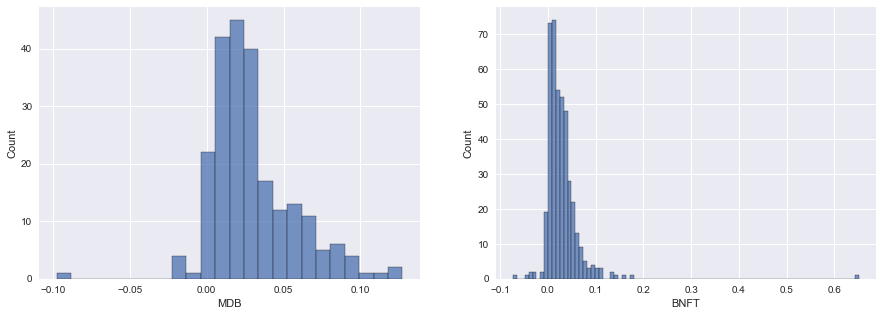

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

t1 = low_thresh_stats.sort_values('prob_neg').iloc[0]['ticker']
t2 = low_thresh_stats.sort_values('prob_neg').iloc[1]['ticker']

sns.histplot(returns[t1], ax=ax1)
sns.histplot(returns[t2], ax=ax2)

print(f'{t1} skew: {returns[t1].skew()}')
print(f'{t2} skew: {returns[t2].skew()}')

ASML skew: 0.8696334854482034
TSM skew: 1.1470922159801051


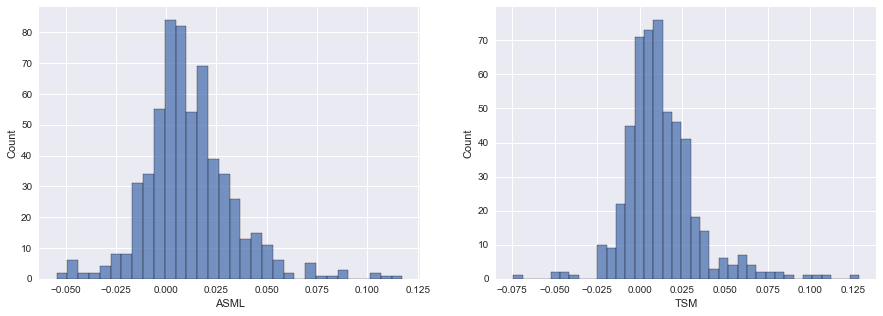

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

t1 = low_thresh_stats.sort_values('prob_neg', ascending=False).iloc[0]['ticker']
t2 = low_thresh_stats.sort_values('prob_neg', ascending=False).iloc[1]['ticker']

sns.histplot(returns[t1], ax=ax1)
sns.histplot(returns[t2], ax=ax2)

print(f'{t1} skew: {returns[t1].skew()}')
print(f'{t2} skew: {returns[t2].skew()}')

In [26]:
# np.histogram(returns['SPWR'], bins=[-1, -.5] + list(np.linspace(0, 1, num=11)))

## Returns for limit sells

Could be good to look at proportion of sells that actually hit the limit. For a low limit, Sharpe ratio becomes unreliable as the standard deviation of returns becomes very low since more sells are at the limit

In [27]:
limit = 0.05

limit_stats_df = calculate_stats_for_thresholds(
    close_prices, hi_prices, tm.threshold_momentum_limit_returns, limit)

limit_last_3y_stats_df = calculate_stats_for_thresholds(
    close_prices.last('3Y'), hi_prices.last('3Y'), tm.threshold_momentum_limit_returns, limit)

In [28]:
limit_last_3y_stats_df.sort_values('sharpe', ascending=False).head(10)

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std
541,DOCU,0.018602,0.05,0.619556,25,18,7,0.030025
167,ABNB,0.024894,0.03,0.615573,12,9,3,0.040440
532,CTXS,0.016525,0.05,0.598561,8,5,3,0.027608
332,ABNB,0.022612,0.04,0.543605,11,8,3,0.041596
638,TWLO,0.015126,0.05,0.526721,33,24,9,0.028716
656,ZG,0.017807,0.05,0.491354,33,26,7,0.036240
473,TWLO,0.013746,0.04,0.483535,50,39,11,0.028428
497,ABNB,0.019873,0.05,0.464453,10,7,3,0.042787
375,DKNG,0.018527,0.04,0.448516,64,43,19,0.041306
84,MCFE,0.014885,0.02,0.424298,20,13,7,0.035081


In [29]:
limit_stats_df.sort_values('sharpe', ascending=False).head(10)

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std
167,ABNB,0.024894,0.03,0.615573,12,9,3,0.040440
332,ABNB,0.022612,0.04,0.543605,11,8,3,0.041596
497,ABNB,0.019873,0.05,0.464453,10,7,3,0.042787
375,DKNG,0.018527,0.04,0.448516,64,43,19,0.041306
84,MCFE,0.014885,0.02,0.424298,20,13,7,0.035081
288,SNOW,0.016353,0.03,0.407604,20,16,4,0.040119
540,DKNG,0.016065,0.05,0.394406,50,32,17,0.040731
427,NIO,0.015385,0.04,0.383801,136,90,46,0.040087
592,NIO,0.015531,0.05,0.381058,107,71,36,0.040759
2,ABNB,0.017727,0.02,0.380800,13,9,4,0.046551


Estimated p-value for ABNB sharpe ratio of 0.62 is 0.0632


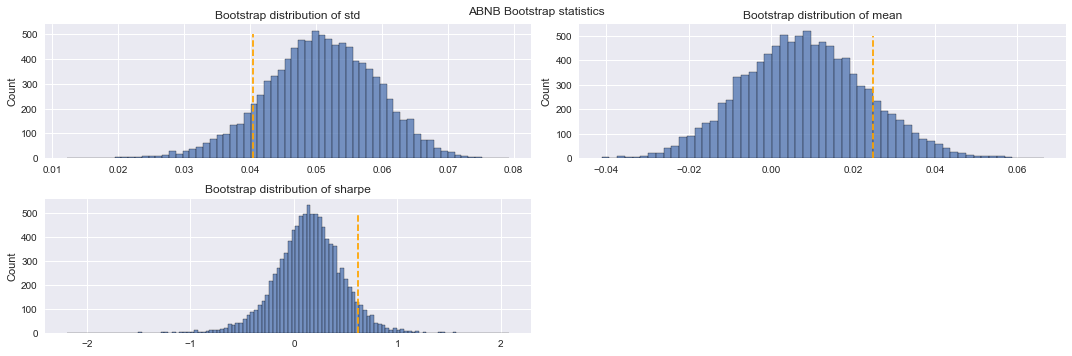

In [30]:
visualize_bootstrap(close_prices.pct_change(), limit_stats_df, 167)

Estimated p-value for DOCU sharpe ratio of 0.62 is 0.0082


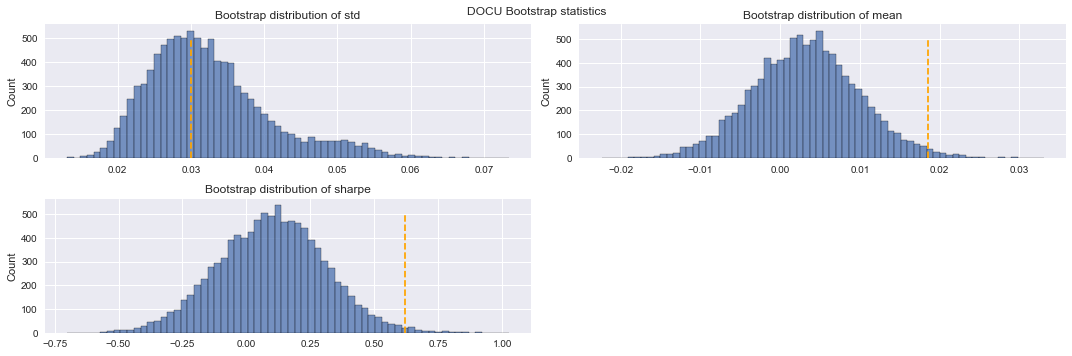

In [31]:
visualize_bootstrap(close_prices.pct_change(), limit_last_3y_stats_df, 541)

In [32]:
limit_stats_df['p_value'] = limit_stats_df.apply(
    lambda row: p_value_for_row(close_prices.pct_change(), row),
    axis=1)

In [33]:
limit_stats_df.sort_values('p_value').head(10)

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std,p_value
592,NIO,0.015531,0.05,0.381058,107,71,36,0.040759,0.000
427,NIO,0.015385,0.04,0.383801,136,90,46,0.040087,0.000
375,DKNG,0.018527,0.04,0.448516,64,43,19,0.041306,0.004
45,DKNG,0.015084,0.02,0.374174,100,62,35,0.040312,0.004
491,ZG,0.007818,0.04,0.241092,219,131,88,0.032425,0.004
656,ZG,0.010234,0.05,0.296741,126,81,45,0.034487,0.005
210,DKNG,0.015104,0.03,0.374931,86,53,31,0.040286,0.009
549,ETSY,0.010945,0.05,0.300582,92,58,32,0.036414,0.009
262,NIO,0.010917,0.03,0.243305,160,99,61,0.044869,0.011
161,ZG,0.005040,0.02,0.155898,542,300,241,0.032328,0.013


Although p-values can be low here, the sharpe ratios are so low and the proportion of changes that are negative is often so high that it isn't appealing

Estimated p-value for ZG sharpe ratio of 0.30 is 0.0019


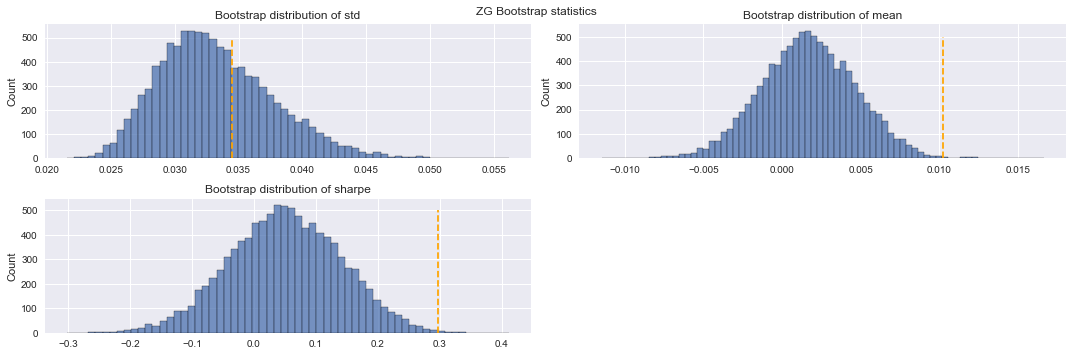

In [34]:
visualize_bootstrap(close_prices.pct_change(), limit_stats_df, 656)

# Holdout Strategy

Sell if limit hit, otherwise hold until buy price is met again.

The key here is really understanding how to evaluate the drawdowns. Without that these results look fantastic as you can always score positive returns. Much more work needs to be done on that.

In [35]:
from evaluation.threshold_momentum import calculate_stats_with_drawdowns_for_thresholds

In [36]:
limit = 0.05

holdout_stats_df = calculate_stats_with_drawdowns_for_thresholds(
    close_prices, hi_prices, tm.threshold_momentum_holdout_returns, limit)

holdout_last_3y_stats_df = calculate_stats_with_drawdowns_for_thresholds(
    close_prices.last('3Y'), hi_prices.last('3Y'), tm.threshold_momentum_holdout_returns, limit)

In [37]:
# :TODO: important statistic to add: drawdown durations

holdout_last_3y_stats_df.sort_values('sharpe', ascending=False)

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std,mean_dd,count_dd,max_dd
440,QS,0.047766,0.04,5.508361,23,23,0,0.008672,-0.158280,47,-0.620567
605,QS,0.047664,0.05,5.378763,22,22,0,0.008862,-0.161450,38,-0.620567
38,DASH,0.046859,0.02,4.973023,9,9,0,0.009423,-0.083448,16,-0.163270
310,U,0.046477,0.03,4.816052,28,28,0,0.009650,-0.069338,48,-0.163736
203,DASH,0.046467,0.03,4.649327,8,8,0,0.009994,-0.083448,16,-0.163270
...,...,...,...,...,...,...,...,...,...,...,...
88,MRK,0.014300,0.02,0.836874,24,24,0,0.017087,-0.042185,149,-0.128550
454,SPGI,0.012191,0.04,0.818253,10,10,0,0.014899,-0.064513,27,-0.221765
575,LMT,0.019469,0.05,0.815361,6,6,0,0.023877,-0.048690,66,-0.225481
31,COST,0.007744,0.02,0.814443,18,18,0,0.009508,-0.027487,89,-0.095507


Estimated p-value for DASH sharpe ratio of 4.97 is 0.0000


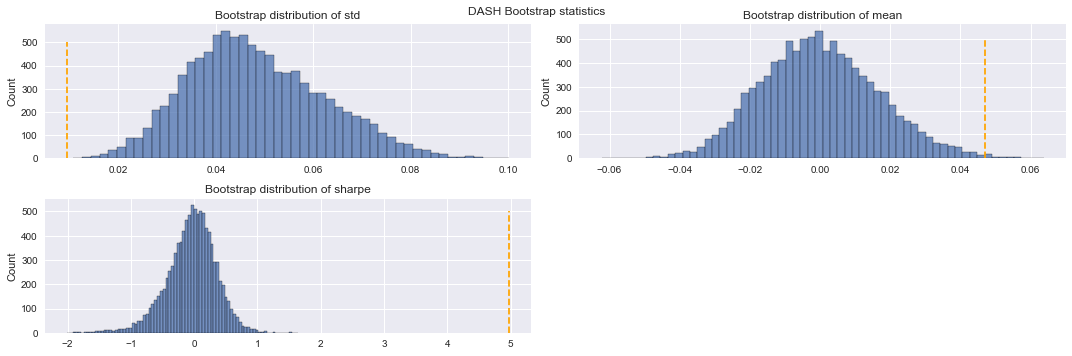

In [38]:
visualize_bootstrap(close_prices.pct_change(), holdout_last_3y_stats_df, 38)

Estimated p-value for QS sharpe ratio of 5.51 is 0.0000


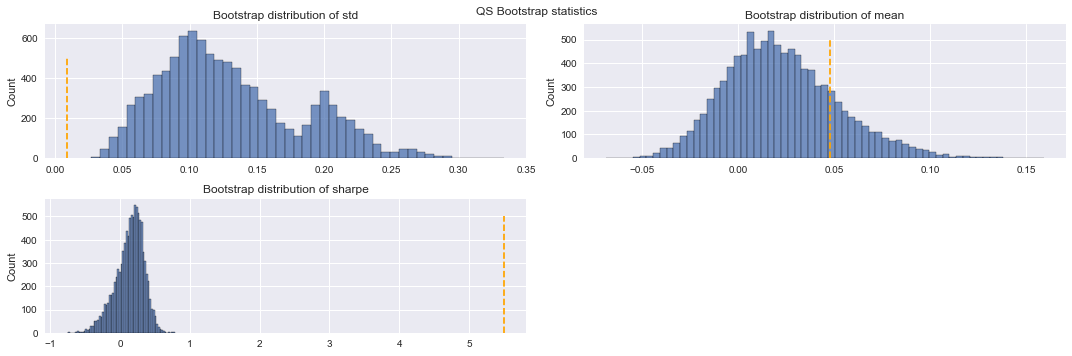

In [39]:
visualize_bootstrap(close_prices.pct_change(), holdout_last_3y_stats_df, 440)

In [40]:
holdout_last_3y_stats_df[holdout_last_3y_stats_df['count'] > 100].sort_values('sharpe', ascending=False).head()

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std,mean_dd,count_dd,max_dd
98,NLS,0.040303,0.02,2.454227,116,114,0,0.016422,-0.111225,258,-0.568323
427,NIO,0.039978,0.04,2.374857,101,100,0,0.016834,-0.098373,183,-0.602410
262,NIO,0.039878,0.03,2.310353,111,110,0,0.017260,-0.106940,254,-0.602410
97,NIO,0.039189,0.02,2.233606,139,136,0,0.017545,-0.091381,272,-0.602410
26,BYND,0.038621,0.02,2.207181,101,101,0,0.017498,-0.079410,207,-0.406243


In [41]:
holdout_returns, drawdowns = tm.threshold_momentum_holdout_returns(close_prices, hi_prices, 0.02, 0.05)

Weird looking graph, but surprisingly insightful

<AxesSubplot:xlabel='date'>

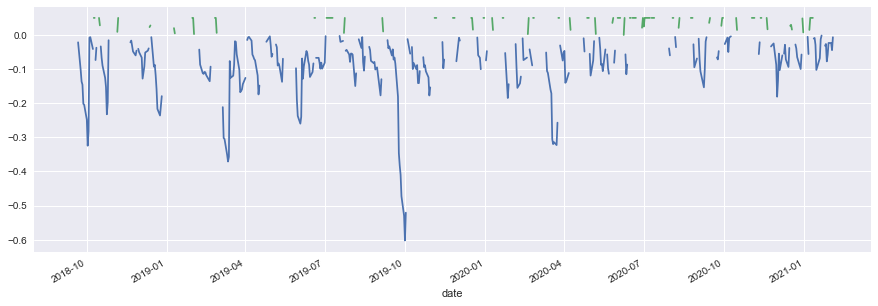

In [42]:
drawdowns['NIO'].plot()
holdout_returns['NIO'].plot()

Estimated p-value for NLS sharpe ratio of 2.45 is 0.0000


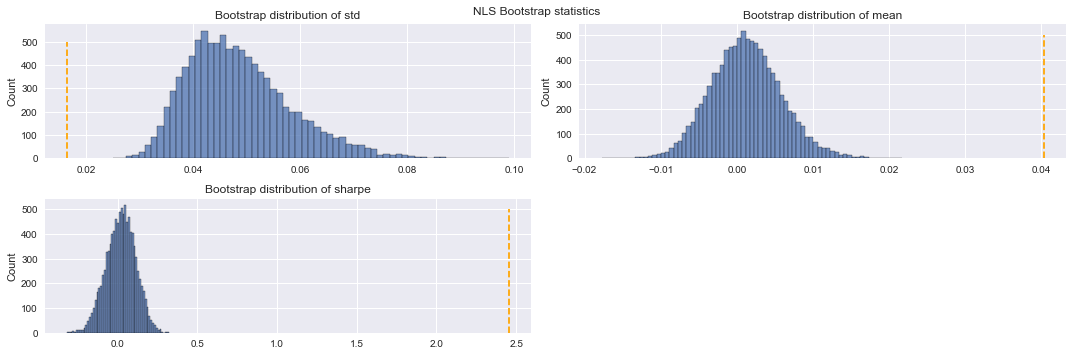

In [43]:
visualize_bootstrap(close_prices.pct_change(), holdout_last_3y_stats_df, 98)